# imports

In [1]:
import thunderfish.dataloader as dl
import thunderfish.pulsetracker as pt
import thunderfish.eventdetection as ed
import matplotlib.pyplot as plt
import numpy as np
import os

# parameters and functions


In [2]:
def plot_peaks(x,y,peaksx,peaksy,c='k'):
    plt.figure(figsize=(10,5))
    plt.plot(x,y,zorder=-1)
    plt.scatter(starttime + peaksx/data.samplerate,peaksy,c=c)
    plt.xlabel('time [s]')
    plt.ylabel('signal')
    
def plot_events_on_data(peaks, data):
    
    """
        plots the detected events onto the data timeseries. If the events are classified, the classes are plotted in different colors and the class -1 (not belonging to a cluster) is plotted in black
    """
    plt.plot(range(len(data)),data, color = 'black')
    plt.axis('off')
    if len(peaks)>3:
        classlist =  np.array(peaks[3],dtype=np.int)
        if len(peaks) > 4:
            classlist = np.array(peaks[4],dtype=np.int)
        cmap = plt.get_cmap('jet')
        colors =cmap(np.linspace(0, 1.0, 3000)) #len(np.unique(classlist))))
        np.random.seed(3)
        np.random.shuffle(colors)
        colors = [colors[cl] for cl in np.unique(classlist)]
        for cl, color in zip(np.unique(classlist), colors):
            if min(classlist) == 0 and cl == 0:
                color = 'black'
            if cl == -1:
                color = 'black'
            
            peaksofclass = peaks[:,classlist == cl]
            if cl == 1:
                colorr = 'r'
            else:
                colorr = 'b'
            plt.plot(peaksofclass[0],peaksofclass[1], '.', color = colorr,   ms =20, label=cl)
    else:
        plt.scatter(peaks[0],peaks[1], color = 'red')
    #plt.legend()

# load data

In [3]:
# create list of filepaths..
text_file = open("leticia_filenames_sorted.txt", "r")
lines = text_file.read().split('\n')
i = 4

In [4]:
filepath = '/home/dexter/' + lines[i][:-4] + '/' + lines[i]

In [5]:
filepath

'/home/dexter/31105L01F14/31105L01F14.WAV'

In [6]:
starttime = 0
endtime = 2   #in seconds

with dl.open_data(filepath, -1, 1.0) as data:
    dt = 1/data.samplerate
    # do something with the content of the file:
    x = np.arange(starttime,endtime,dt)
    y = data[starttime*data.samplerate:endtime*data.samplerate,0]

# online clustering step by step
## 1. EOD detection
Create a data structures with the locations and amplitudes of the EODs

In [7]:
from scipy.interpolate import interp1d
from scipy.signal import correlate
from scipy.signal import argrelextrema

# parameters for the analysis
thresh = 0.1 # minimal threshold for peakdetection
peakwidth = 20 # width of a peak and minimal distance between two EODs

In [8]:
pk, tr = ed.detect_peaks(y, thresh)
peaks = pt.makeeventlist(pk,tr,y,peakwidth)
peakindices, peakx, peakh = pt.discardnearbyevents(peaks[0],peaks[1],peakwidth)
peaks = np.transpose(peaks[:,peakindices])

## 2. Online clustering
create object

In [9]:
class cluster_object(object):
    def __init__(self,label,mean,features,last_idx,peaknum):
        self.label = label
        self.mean = mean
        self.features = features
        self.last_idx = last_idx
        self.idxs = np.zeros(peaknum)
        
def align(eod,cluster_mean,width):
    
    # don't just take max but take a peak of the cc
    # this is to prevent shifting to the next peak in the sequence.
    
    cc = correlate(eod,cluster_mean,'same')
    local_max_idx = argrelextrema(cc[width:-width], np.greater)[0] + width
    diff = np.abs(local_max_idx - len(eod)/2)
    if diff.size > 0:
        offset = local_max_idx[np.argmin(diff)]
    else:
        offset = int(len(eod)/2)
    return extract(eod,offset,width)
    
def extract(eod,offset,width):
    return eod[offset-width:offset+width]

def normalize(x):
    return (x-np.mean(x))

cmap = plt.get_cmap('jet')    
colors = cmap(np.linspace(0, 1.0, 3000)) #len(np.unique(classlist))))
np.random.seed(3)
np.random.shuffle(colors)

In [10]:
clusters = []
maxlabel = 1
labels = np.zeros(len(peaks))

# parameters
cutwidth = peakwidth
alignwidth = 70
int_met = 'quadratic'
eta = 0.1
error_threshold = 0.05
npol = 7

#decide on the plotting
plot_steps = False
plot_means = False

if plot_means == True:
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i,p in enumerate(peaks):
    
    if plot_steps == True:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    
    # cut along peak to get the EOD shape
    p_idx = int(p[0])
    p_hight = p[2]
    
    eod = y[p_idx-cutwidth:p_idx+cutwidth]
    
    #interpolate --> maybe this step is not needed anymore
    eod_func = interp1d(range(len(eod)), eod, int_met)
    eod_ip = eod_func(np.arange(0,len(eod)-1,0.1))
    
    # if its slow change this to numpy arrays
    aligned_eods = np.zeros((len(clusters),alignwidth*2))
    c_feats = np.zeros((len(clusters),npol+2))
    
    current_clusters = []
    
    # align peaks with all existing clusters
    # this is what is really slowing down the process. 
    # many clusters make it exponentially slower. can I avoid this loop?
    if len(clusters) > 0:
        
        # I only have to do this every n seconds or every n peaks
        keep = np.zeros(len(clusters))
        for c,cluster in enumerate(clusters):
            # delete clusters that are too far away
            if p_idx - cluster.last_idx < 2000000: #and np.count_nonzero(labels == cluster.label) < 3:
                current_clusters.append(cluster)        
        
        clusters = current_clusters
        
        # ============== start analysis =================
        for c,cluster in enumerate(clusters):
            # aligning to every cluster is not neccesary anymore.
            aligned_eods[c] = align(eod_ip, cluster.mean, alignwidth)
            c_feats[c] = cluster.features
            if plot_steps == True:
                ax1.plot(cluster.mean)
                ax2.plot(cluster.features)
        
        # normalize
        means = normalize(aligned_eods)

        # extract features
        cheb = np.polynomial.chebyshev.chebfit(np.linspace(-1,1,
            aligned_eods.shape[1]), np.transpose(means),npol)

        hfeat = np.ones(cheb.shape[1])*p_hight/2

        #append peak hight to features
        feats = np.transpose(np.vstack([cheb, hfeat]))

        # compute difference in feature vectors
        cluster_errors = np.linalg.norm(feats - c_feats, axis=1)
        
        if plot_steps == True:
            ax1.plot(np.transpose(means),c='k',alpha=0.5)
            ax2.plot(np.transpose(feats),c='k',alpha=0.5)
            ax1.plot(means[np.argmin(cluster_errors)],c='k',linestyle='--',zorder=3)
            ax2.plot(feats[np.argmin(cluster_errors)],c='k',linestyle='--',zorder=3)

        if np.min(cluster_errors) < error_threshold:
            # assign eod to the class with the lowest cluster_error
            labels[i] = clusters[np.argmin(cluster_errors)].label

            #adapt this cluster with learning rate eta
            
            #clusters[np.argmin(cluster_errors)].mean = (1-eta)*  \
            #clusters[np.argmin(cluster_errors)].mean +       \
            #    eta*means[np.argmin(cluster_errors)]

            clusters[np.argmin(cluster_errors)].features = (1-eta)*  \
                clusters[np.argmin(cluster_errors)].features +       \
                eta*feats[np.argmin(cluster_errors)]        

            #clusters[np.argmin(cluster_errors)].features = 
            clusters[np.argmin(cluster_errors)].last_idx = p_idx
            
        else:
            
            if len(clusters) >= 2:
                # check for collisions
                pass
            
            # create new cluster class
            labels[i] = maxlabel
            
            maxlabel = maxlabel + 1
            new_cluster = cluster_object(labels[i],means[0],
                                     feats[0],p_idx,len(peaks))
            clusters.append(new_cluster)
        
        if plot_means == True:
                ax1.plot(means[np.argmin(cluster_errors)],c=colors[int(labels[i])])
                ax2.plot(feats[np.argmin(cluster_errors)],c=colors[int(labels[i])])
    else:
        # create new cluster class
        labels[i] = maxlabel
        maxlabel = maxlabel + 1
        
        # take middle of snip
        mid = int(len(eod_ip)/2)
        eod_ip = extract(eod_ip,mid,alignwidth)
        
        # normalize
        eod_ip = normalize(eod_ip)
        
        # extract features
        cheb = np.polynomial.chebyshev.chebfit(np.linspace(-1,1,
            aligned_eods.shape[1]), eod_ip, npol)
        
        #features = cheb.coef
        features = np.append(cheb, p_hight/2)
        
        new_cluster = cluster_object(labels[i],eod_ip,features,p_idx,len(peaks))
        clusters.append(new_cluster)
    
    
    # save eods every n steps. before saving delete the short classes.
    # save the peaks of the current buffered part to a numpy-memmap on the disk
    # ==> sth like this: save_EOD_events_to_npmmp(thisblock_eods,eods_len,idx==startblock,datasavepath,mmpname)

In [11]:
peaks = np.append(np.transpose(peaks),[labels], axis = 0)

In [12]:
peaks_ns = pt.discard_short_classes(peaks, 3)

# set peaks that don't have many instances to the noise class.

In [13]:
peaks_ns.shape

(4, 69)

In [23]:
plt.axis('off')
for i,c in enumerate(clusters):
    print(c.label)
    if i == 1:
        colorr = 'r'
    else:
        colorr = 'b'
    plt.plot(c.mean,c=colorr)

1.0
2.0


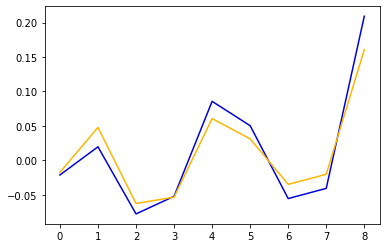

In [15]:
for c in clusters:
    plt.plot(c.features,c=colors[int(c.label)])

In [16]:
%matplotlib qt
plot_events_on_data(peaks_ns,y)

In [17]:
len(clusters)

2

In [18]:
aligned_eods.shape

(2, 140)

In [19]:
print(peaks[0])

[ 1299.  1921.  2932.  3978.  4564.  6029.  6191.  7826.  8089.  9468.
 10149. 11104. 12203. 12741. 14257. 14376. 16017. 16313. 17663. 18377.
 19318. 20440. 20977. 22497. 22643. 24312. 24548. 25986. 26602. 27663.
 28660. 29341. 30718. 31022. 32704. 32777. 34377. 34826. 36046. 36872.
 37713. 38920. 39384. 40971. 41064. 42748. 43024. 44437. 45080. 46130.
 47107. 47824. 49146. 49525. 51196. 51227. 52931. 53250. 54641. 55301.
 56350. 57353. 58057. 59399. 59766. 61447. 61471. 63179. 63499.]


In [20]:
len(clusters)

2

In [21]:
a

NameError: name 'a' is not defined

In [ ]:
len(peaks)